In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")

print(sns.__version__)

0.11.0


In [3]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [61]:
%%time
train = pd.read_csv('/content/drive/My Drive/PUBG Data/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('/content/drive/My Drive/PUBG Data/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: user 25.6 s, sys: 2.57 s, total: 28.2 s
Wall time: 29.9 s


In [144]:
train.shape

(4446772, 32)

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [63]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


In [64]:
train.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0,0,0.000,0,0,1019.000000,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0,0,0.000,0,0,81.699997,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0,0,2.184,0,0,788.700012,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0,0,0.000,0,0,2748.000000,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.000000,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0,0,0.000,0,0,1244.000000,5,0,0.5464


Exploratory Data Analysis (EDA)


In [ ]:
#unique count for id
for i in ['Id','groupId','matchId']:
    print(f'unique [{i}] count:', train[i].nunique())

unique [Id] count: 4446966
unique [groupId] count: 2026745
unique [matchId] count: 47965


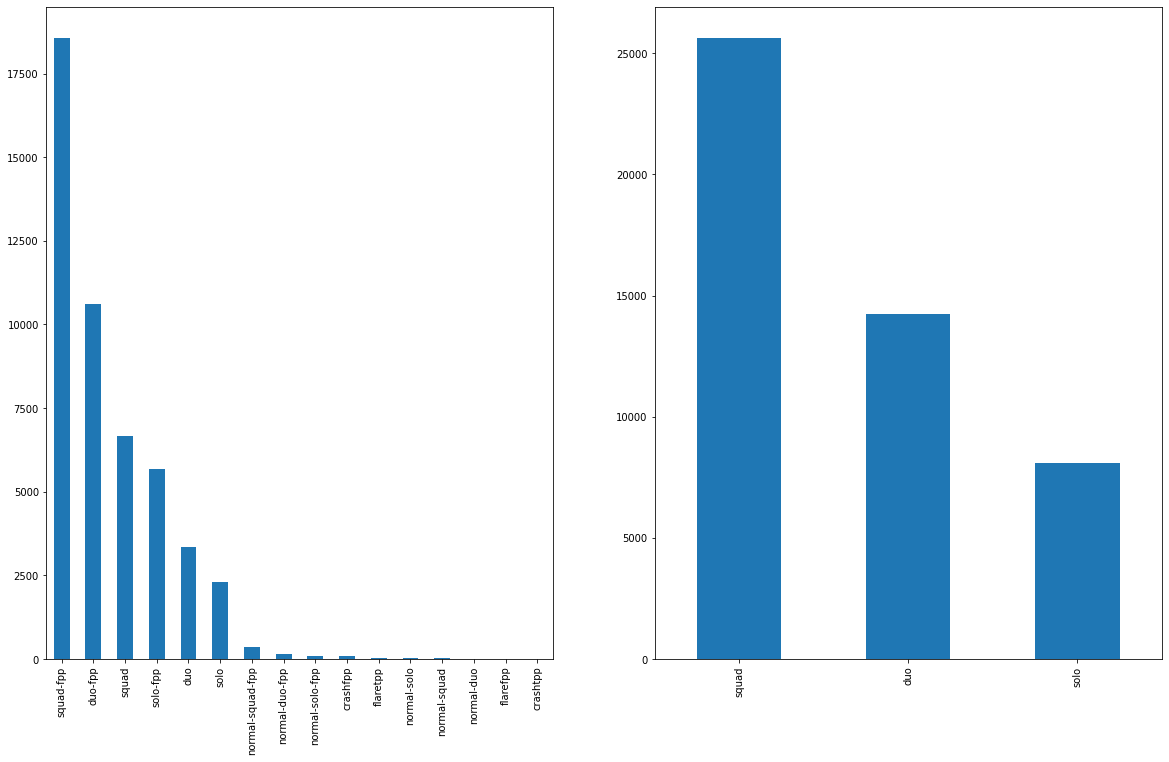

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

In [10]:
def mergeList(list1,list2):
    return list(itertools.product(list1,list2))
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[mergeList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[mergeList(['players in group'],['min','mean','max'])]], axis=1)

players in match                   players in group                
                       min       mean    max              min      mean   max
matchType                                                                    
duo                    7.0  92.985658  100.0              1.0  2.050456  72.0
solo                   1.0  89.031872  100.0              1.0  1.039249  64.0
squad                  5.0  93.723193  100.0              1.0  3.492575  74.0

In [11]:
print(group['players in group'].nlargest(5)) 

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


In [12]:
subset = train[train['matchId']=='3e029737889ce9']
sub_grp = subset[subset['groupId']=='b8275198faa03b']

print('matchId ==\'3e029737889ce9\' & groupId ==\'b8275198faa03b\'')
print('-'*50)
print('players:',len(subset))
print('groups:',subset['groupId'].nunique())
print('numGroups:',subset['numGroups'].unique())
print('maxPlace:',subset['maxPlace'].unique())
print('-'*50)
print('max-group players:',len(sub_grp))
print('max-group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('-'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())

matchId =='3e029737889ce9' & groupId =='b8275198faa03b'
--------------------------------------------------
players: 99
groups: 14
numGroups: [14]
maxPlace: [50]
--------------------------------------------------
max-group players: 72
max-group winPlacePerc: [0.2449]
--------------------------------------------------
winPlacePerc: [0.     0.0204 0.0408 0.0612 0.0816 0.102  0.1224 0.1633 0.1837 0.2041
 0.2245 0.2449 0.5102 1.    ]


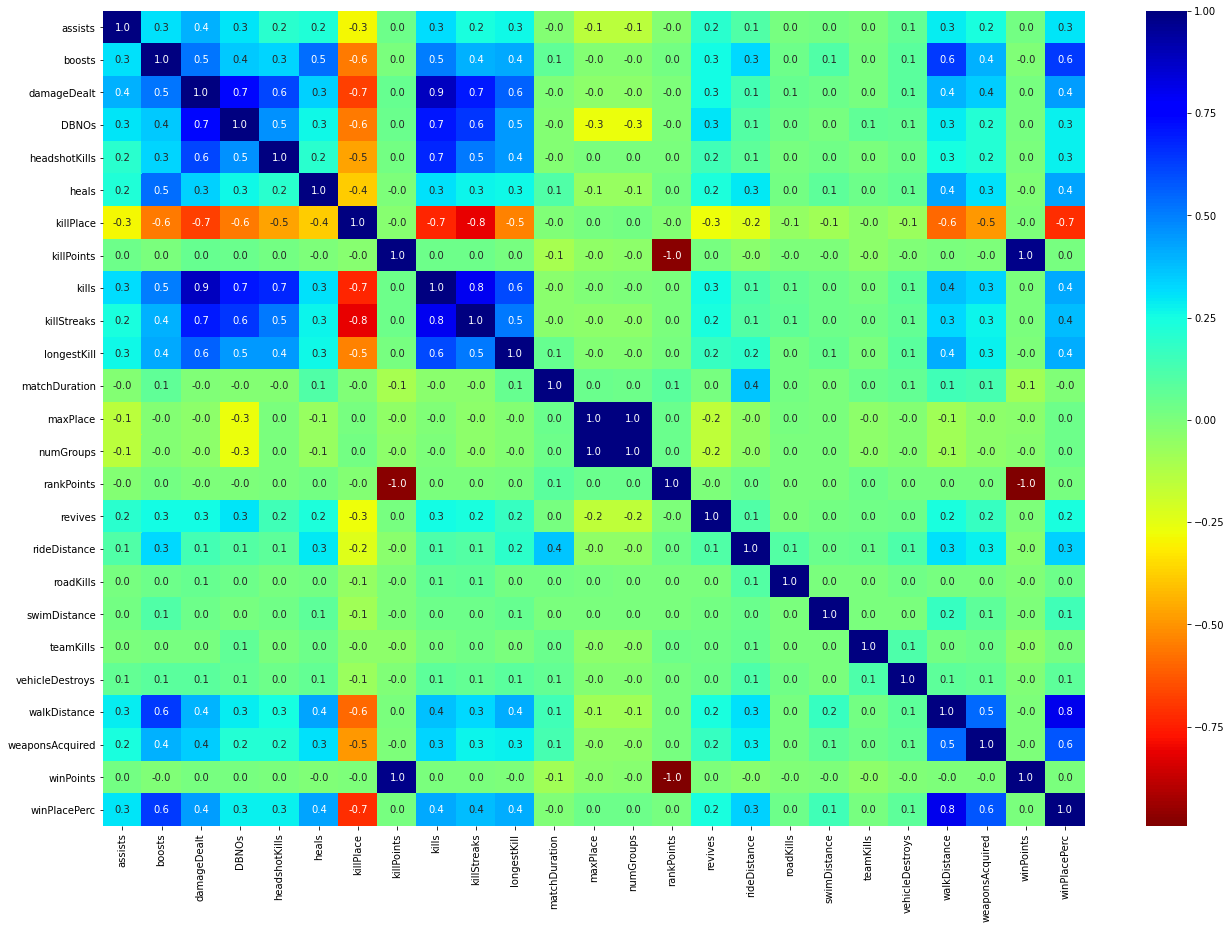

In [ ]:
corr = train.corr()
f,ax = plt.subplots(figsize=(22,15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f',ax=ax, cmap="jet_r")
sns.set(font_scale=1.50)
plt.show()

Featured Engineering

In [ ]:
print("On an average a person kills {:.4f} players, 99% of people have {} kills or less, while the maximum kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

On an average a person kills 0.9248 players, 99% of people have 7.0 kills or less, while the maximum kills ever recorded is 72.


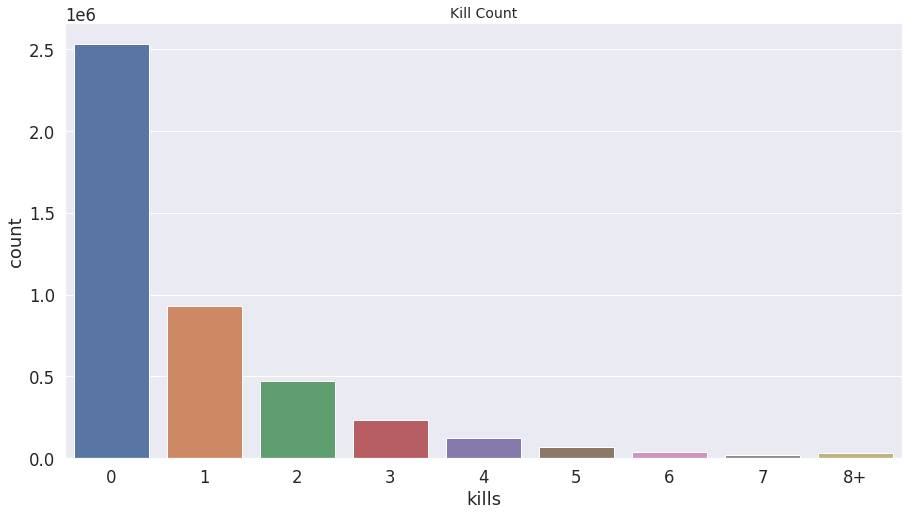

In [ ]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=14)
plt.show()

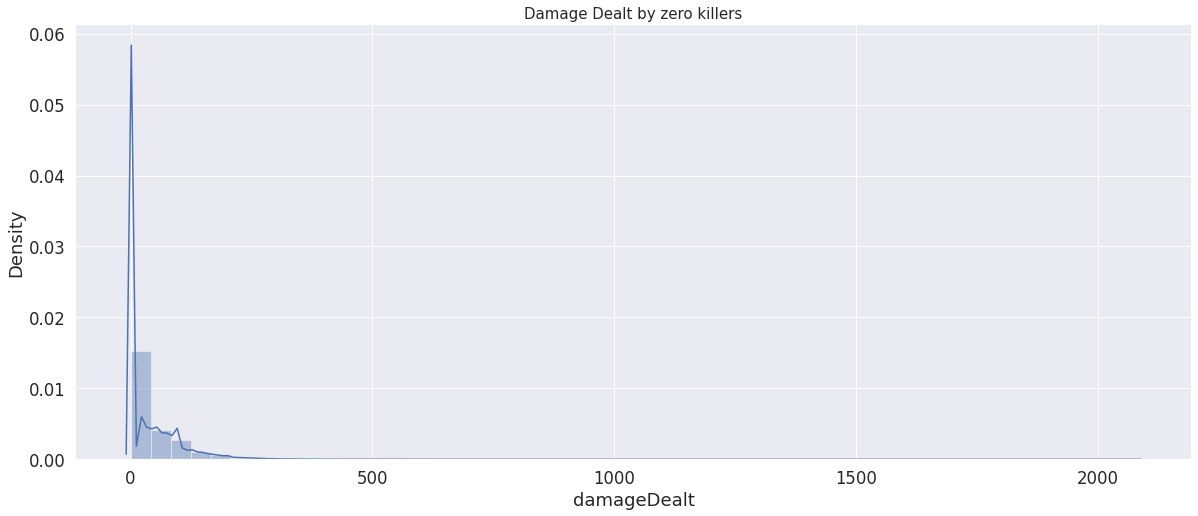

In [ ]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(20,8))
plt.title("Damage Dealt by zero killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

In [ ]:
print("A total of {} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))
data1 = train[train['damageDealt'] == 0].copy()
print("A total of {} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

A total of 16666 players (0.3748%) have won without a single kill!
A total of 4770 players (0.1073%) have won without dealing damage!


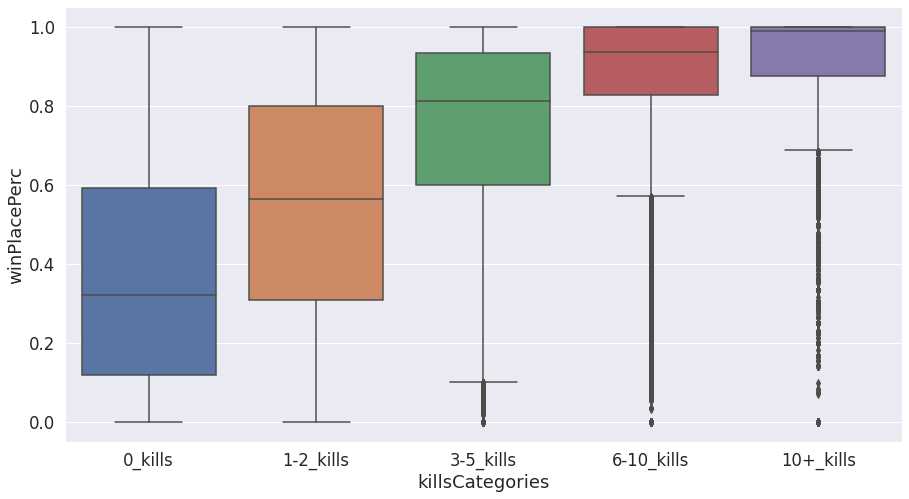

In [ ]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

**RUNNING**

In [ ]:
print("{} players ({:.4f}%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

98054 players (2.0329%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


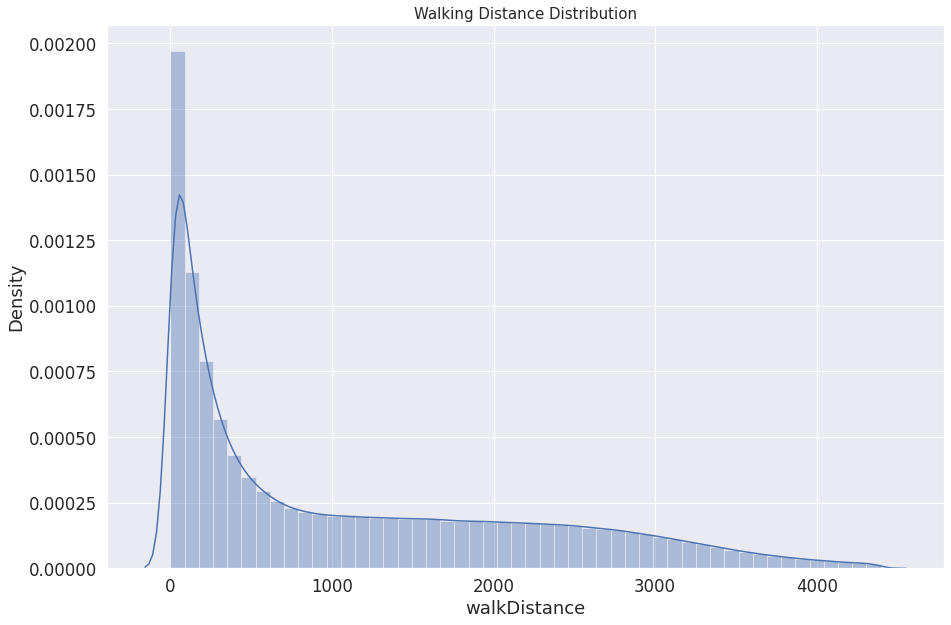

In [ ]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

*Effect of running on Winning Percentage*



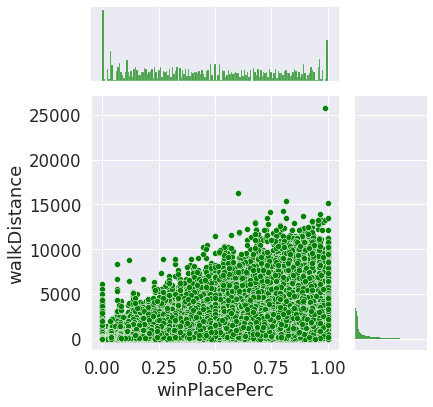

In [ ]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=6, ratio=3, color="green")
plt.show()

**RIDING**

In [ ]:
print("An average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE rider ride for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

An average person drives for 606.1m, 99% of people have drived 6966.0m or less, while THE rider ride for 40710.0m.


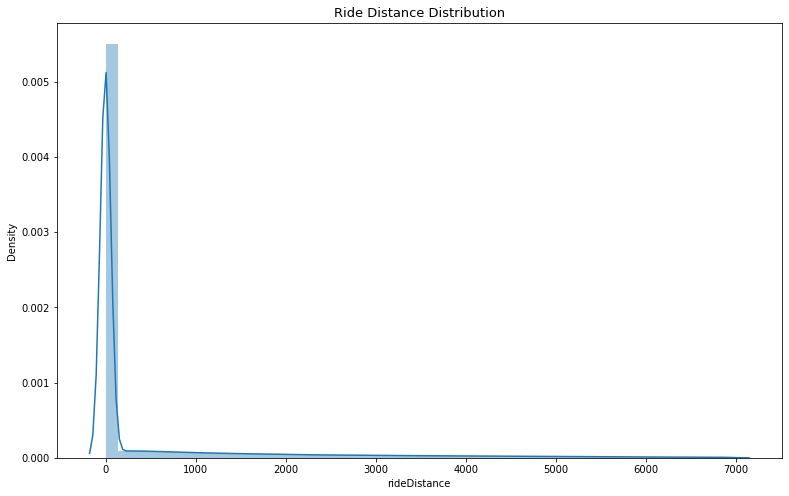

In [65]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(13,8))
plt.title("Ride Distance Distribution",fontsize=13)
sns.distplot(data['rideDistance'])
plt.show()

In [ ]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they like trekking more than riding.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 players (23.1022%) drived for 0 meters. This means that they like trekking more than riding.


*Effect of Riding on Winning Percentage*

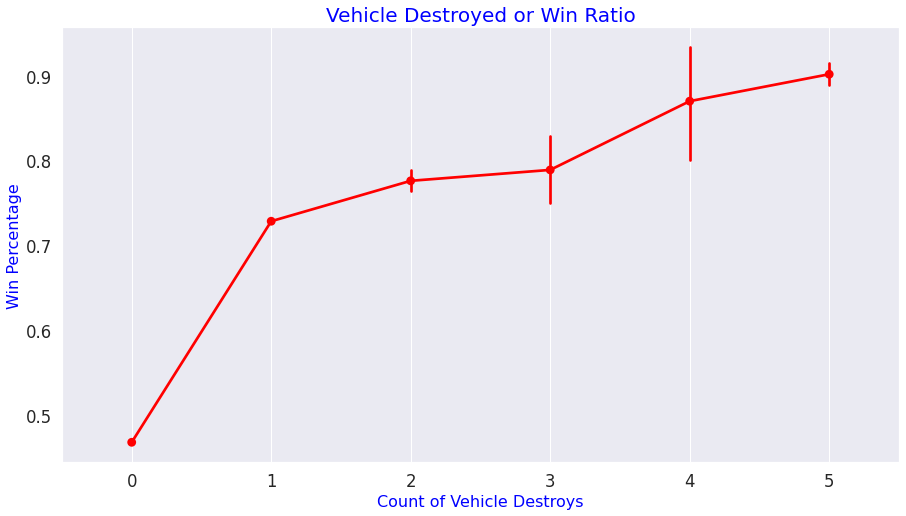

In [ ]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='red',alpha=0.5)
plt.xlabel('Count of Vehicle Destroys',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Vehicle Destroyed or Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

If a player is able to destroy the vehicle it indicates that player might get eliminated or knockout which leads to increase in win Ratio

**Healing and Boosting**

In [ ]:
print("In the game on an average a person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("In the game on an average a person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

In the game on an average a person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
In the game on an average a person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


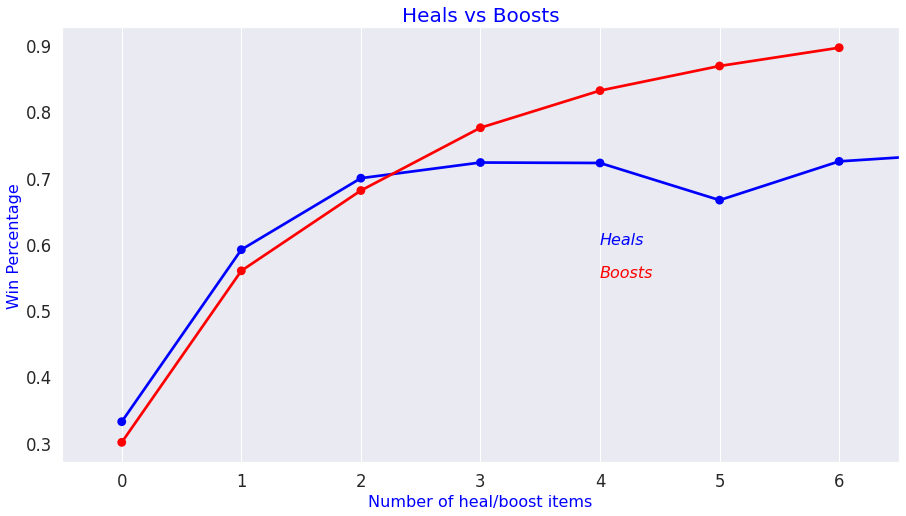

In [ ]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='blue',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='red',alpha=0.8)
plt.text(4,0.6,'Heals',color='blue',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='red',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

*Effect of Healing & Boosting on Winning Percentage*

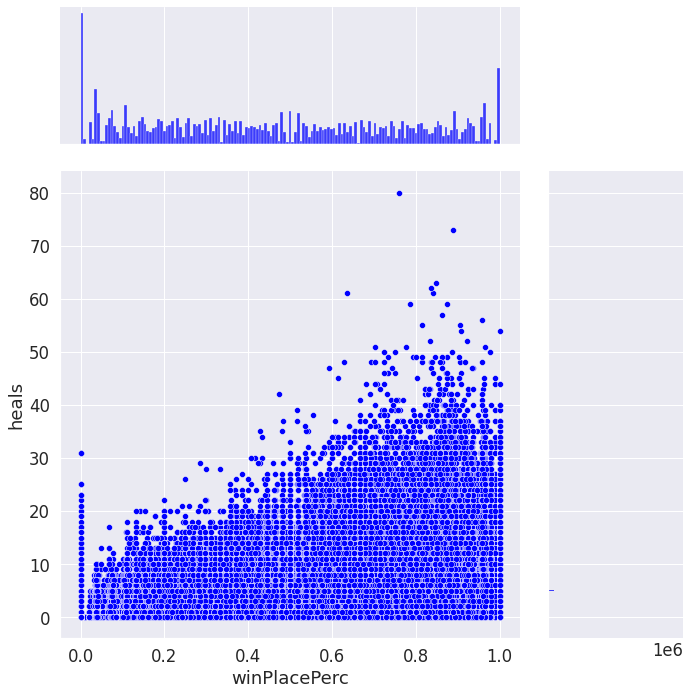

In [ ]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="blue")
plt.show()

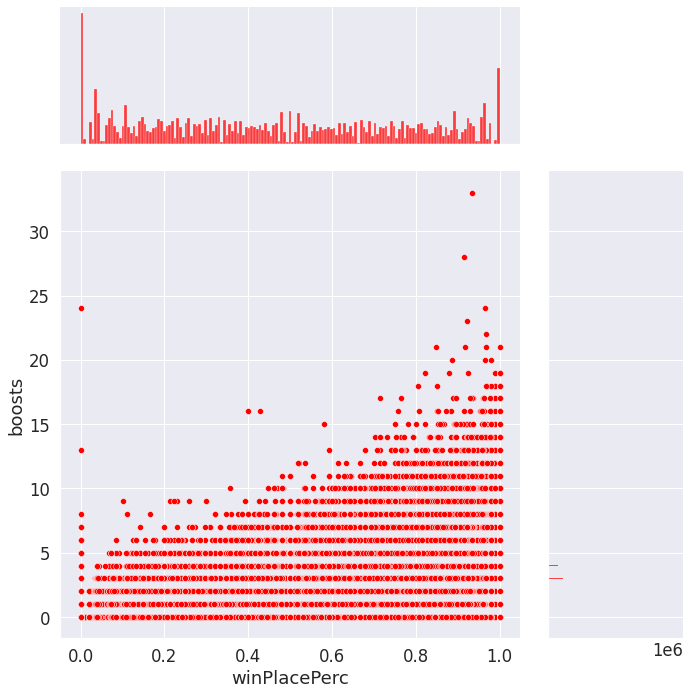

In [ ]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="red")
plt.show()

*Healing and Boosts have a high correlation with winning, however boosts matter more. However we can see abnormal behaviour at starting point*

# *Effect of Killing  Solo, Duos and Squad on Winning Percentage*

In [ ]:
solos = train[train['numGroups']>50] #Solo game > 50 players
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)] #for Duo max 50duos 
squads = train[train['numGroups']<=25] # For Squad max 25squads
print("{} ({:.2f}%) of games are solo, {} ({:.2f}%) are duo and {} ({:.2f}%) are squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

709111 (15.95%) of games are solo, 3295326 (74.10%) are duo and 442529 (9.95%) are squad games.


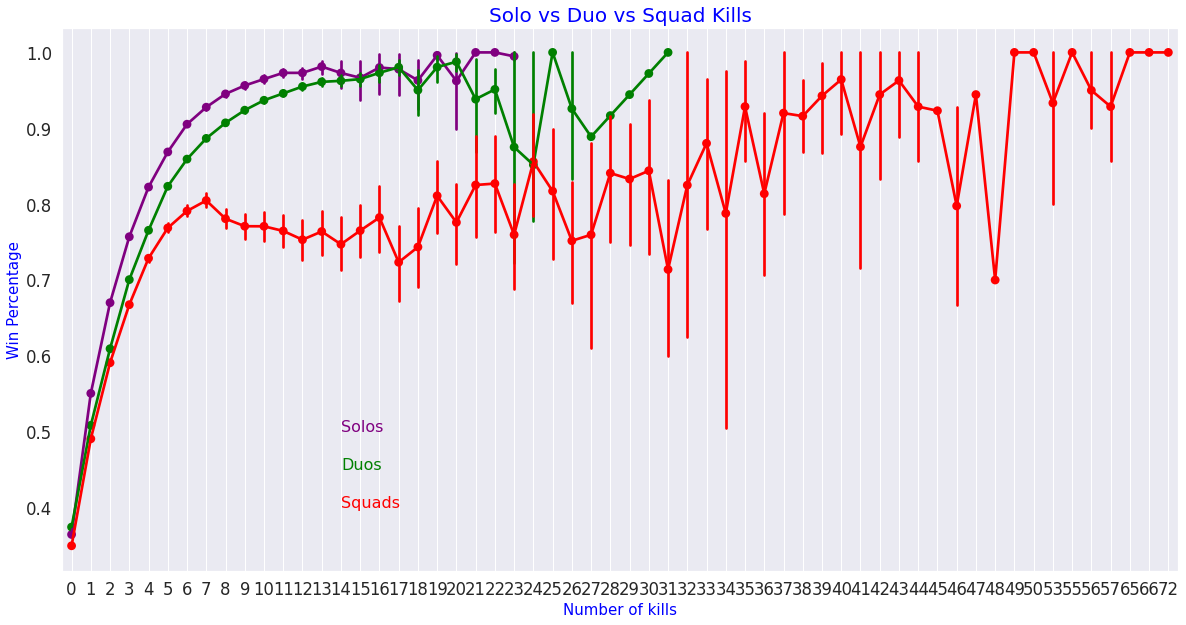

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='purple',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='green',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='red',alpha=0.6)
plt.text(14,0.5,'Solos',color='purple',fontsize = 16)
plt.text(14,0.45,'Duos',color='green',fontsize = 16)
plt.text(14,0.4,'Squads',color='red',fontsize = 16)
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

# *Effect of Knocking (DBNOs), Assisting or Reviving on Winning Percentage*

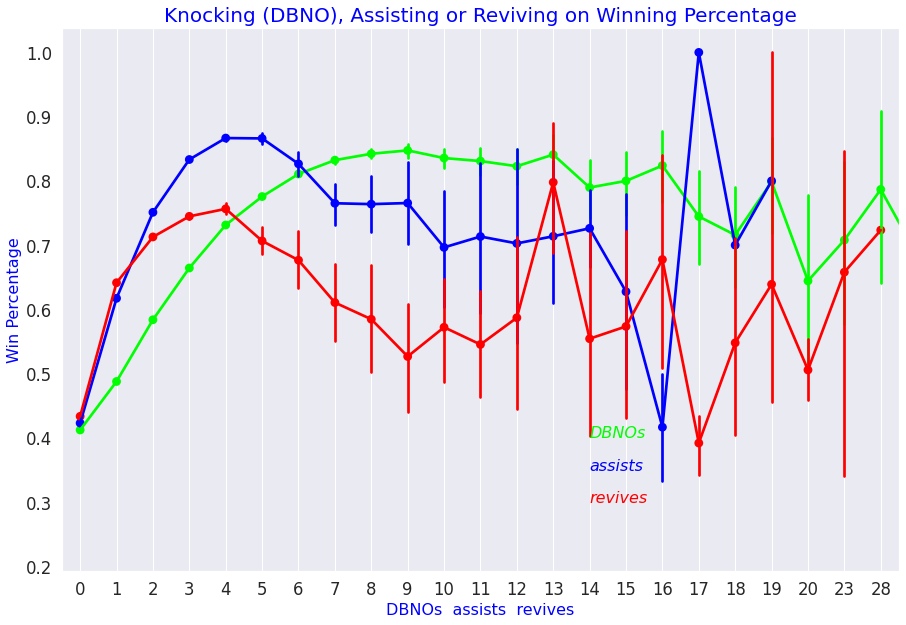

In [ ]:

f,ax1 = plt.subplots(figsize =(15,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=data,color='blue',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=data,color='red',alpha=0.8)
plt.text(14,0.4,'DBNOs',color='lime',fontsize = 16,style = 'italic')
plt.text(14,0.35,'assists',color='blue',fontsize = 16,style = 'italic')
plt.text(14,0.3,'revives',color='red',fontsize = 16,style = 'italic')
plt.xlabel('DBNOs  assists  revives',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Knocking (DBNO), Assisting or Reviving on Winning Percentage',fontsize = 20,color='blue')
plt.grid()
plt.show()

# ***HACKERS.....***

In [14]:
#illegal matches with NaN value
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [15]:
train.drop(train[train['winPlacePerc'].isnull()].index, inplace=True)

In [16]:
#Dimensions
train.shape

(4446965, 29)

# ***AIM HACK..***

In [66]:
#New Feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

In [68]:
# New Feature headshot_rate feature --- headshots made per kill
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

In [69]:
#Defining some functions for plotting graphs
def show_countplot(column):
    plt.figure(figsize=(15,8))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(15, 8))
    sns.distplot(train[column], bins=50)
    plt.show()

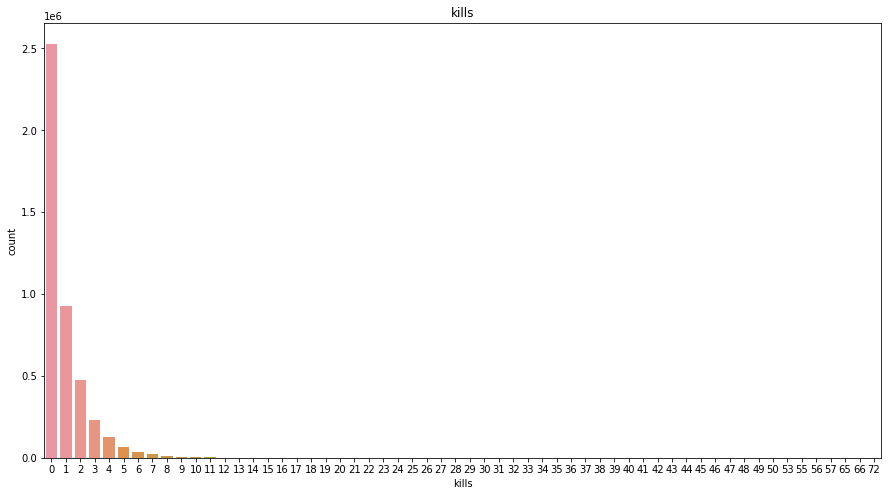

In [20]:
show_countplot('kills')

In [70]:
train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['totalDistance'] < 100.0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.949997,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,23.709999,61,0,0.7000,23.709999,0.250000
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5793.0,0,5,2,1,0,57,5,104.199997,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,24.270000,56,0,1.0000,24.270000,0.087719
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5557.0,0,7,4,1,0,55,6,74.790001,1798,normal-solo-fpp,19,18,1500,0,0.0,0,0.0,0,0,85.550003,66,0,1.0000,85.550003,0.127273
1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3707.0,0,5,1,5,0,41,4,188.100006,1798,normal-solo-fpp,19,18,1500,0,0.0,0,0.0,0,0,46.709999,72,0,0.7778,46.709999,0.121951


In [22]:
train[(train['kills'] >= 40) & (train['heals'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.200012,844,squad,8,8,-1,0,0.0,0,0.0,1,0,718.299988,16,1500,1.0,718.299988,0.952381
2105633,770c02791306c4,48ca6706a90e10,6ee2c835176181,8,0,4272.0,40,34,0,1,0,43,9,248.800003,911,squad,6,6,1500,1,0.0,0,0.0,0,0,80.400002,21,0,1.0,80.400002,0.790698
2316123,dbc81aa64a7e3d,c50fe5c54e8bb6,5d58307bae9b50,8,0,4106.0,31,3,0,1,0,40,6,365.200012,1066,squad,10,9,1500,0,0.0,0,0.0,0,0,1282.000000,22,0,1.0,1282.000000,0.075000
2601666,436d1530e9eb00,5c974c2bb9d9f0,fe7043ee6221c8,5,0,4347.0,0,31,0,1,0,53,8,135.600006,1116,solo,37,26,1500,0,0.0,0,0.0,0,0,134.300003,36,0,1.0,134.300003,0.584906
3924729,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,1000,40,20,621.799988,799,squad,10,10,-1,0,0.0,0,0.0,0,0,1180.000000,2,1500,1.0,1180.000000,0.875000


In [24]:
# Drop 'fraudsters' with inhumane kill counts
train.drop(train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['totalDistance'] < 100.0)].index, inplace=True)
train.drop(train[(train['kills'] >= 40) & (train['heals'] == 0)].index, inplace=True)

# 100% HeadShots

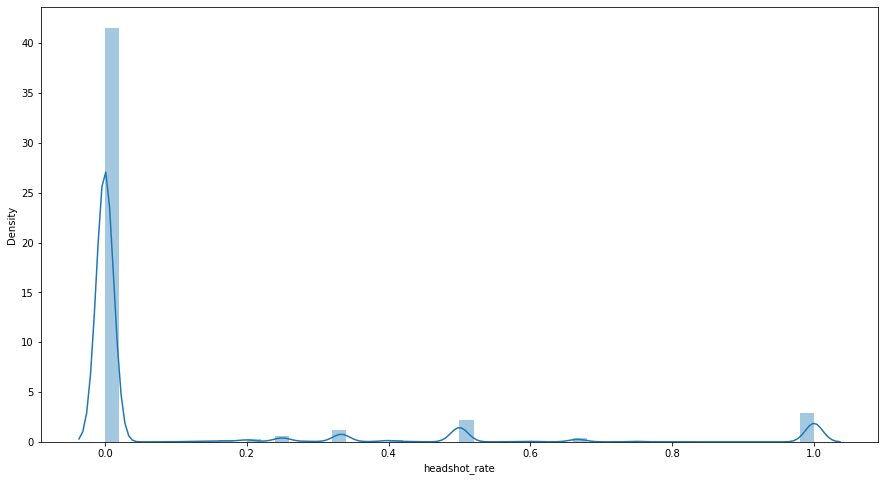

In [25]:
show_distplot('headshot_rate')

In [71]:
# Player having  more than 10 kills and all the kills were done by headshot
display(train[(train['headshot_rate'] == 1) & (train['kills'] >=10)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] >= 10)].head(10)

(24, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.199997,1423,squad-fpp,27,25,1564,1,0.000000,0,0.000000,0,0,2939.0,5,0,0.8462,2939.000000,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.599976,1727,squad,27,26,-1,3,4720.000000,0,0.000000,0,0,3422.0,8,1560,1.0000,8142.000000,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.799988,1255,squad,27,27,-1,0,0.000000,0,0.000000,0,0,2105.0,5,1587,1.0000,2105.000000,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.200012,1838,squad-fpp,28,24,-1,0,5187.000000,0,0.000000,2,0,2761.0,7,1519,0.9630,7948.000000,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.000000,1417,squad,27,26,-1,0,1018.000000,0,0.000000,0,0,2458.0,4,1562,1.0000,3476.000000,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.899994,1821,squad-fpp,28,27,1495,0,5246.000000,0,0.000000,0,0,2932.0,4,0,1.0000,8178.000000,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.000000,1246,squad-fpp,27,27,-1,0,408.899994,0,0.000000,0,0,2450.0,7,1468,1.0000,2858.899902,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.000000,1730,squad-fpp,28,28,1560,0,2048.000000,0,0.000000,0,0,3915.0,5,0,1.0000,5963.000000,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.600006,1248,duo,46,41,0,1,0.000000,0,0.000000,0,0,3108.0,7,1500,1.0000,3108.000000,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.139999,1379,duo-fpp,49,48,1813,0,0.000000,0,140.800003,0,0,2339.0,4,0,1.0000,2479.800049,1.0


In [72]:
# Create feature killsWithoutMoving
train['_killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))
# Check players who kills without moving
display(train[train['_killsWithoutMoving'] == True].shape)
train[train['_killsWithoutMoving'] == True].head(10)

(1535, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.540001,593,normal-squad-fpp,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.000000,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,0,3,1,6.523000,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,0.0,0.000000,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.080002,898,normal-solo-fpp,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,0.0,0.200000,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,1000,1,1,21.540001,799,normal-squad-fpp,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,0.0,0.000000,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.430000,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,0.0,1.000000,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.100006,4,1,3,7,0,6,2,81.919998,583,normal-squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8000,0.0,0.166667,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,0,12,5,116.300003,550,normal-squad-fpp,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.6000,0.0,0.333333,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.900024,0,2,11,12,0,7,2,84.370003,599,normal-squad-fpp,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.285714,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.899994,0,1,6,53,1000,2,1,26.990000,732,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.2857,0.0,0.500000,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.559998,0,0,0,46,0,1,1,16.440001,715,normal-squad-fpp,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.8571,0.0,0.000000,True


In [29]:
# Drop kill without moving 'fraudsters'
train.drop(train[train['_killsWithoutMoving'] == True].index, inplace=True)

# Killing from unexpected long range

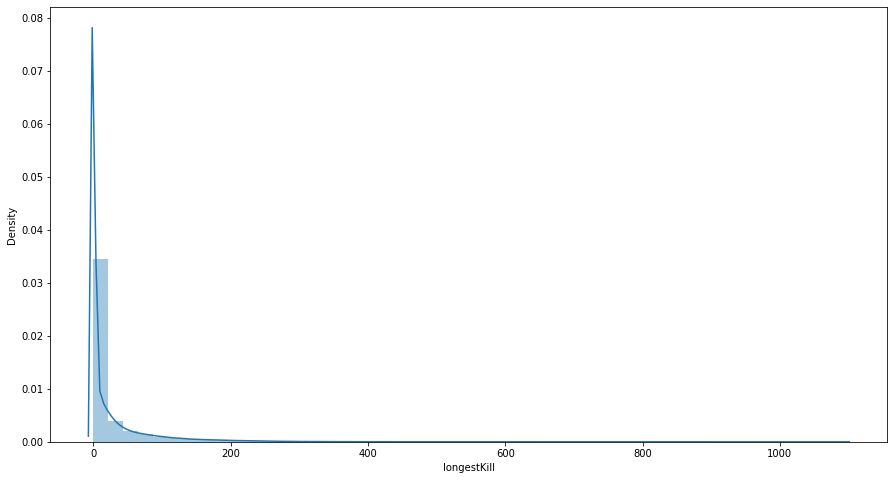

In [30]:
show_distplot('longestKill')

In [31]:
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.900024,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.200012,0,0.000000,0,1,3052.000000,9,0,0.9231,3775.199951,0.250000,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.000000,8,5,7,18,1000,11,2,1004.0,1308,duo,14,13,-1,1,0.000000,0,0.000000,0,0,48.869999,38,1500,0.5385,48.869999,0.454545,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.000000,0,0,0,9,0,10,2,1026.0,698,squad,13,13,1500,0,1717.000000,0,0.000000,0,0,1264.000000,26,0,1.0000,2981.000000,0.000000,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.000000,17,5,0,3,1000,16,4,1000.0,1091,squad,6,6,-1,4,0.000000,0,0.000000,0,0,29.209999,30,1500,0.6000,29.209999,0.312500,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.800003,0,0,0,51,0,1,1,1075.0,471,squad,8,8,1500,0,2085.000000,0,0.000000,0,0,1074.000000,22,0,0.0000,3159.000000,0.000000,False
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.000000,11,5,0,5,0,10,3,1094.0,1021,squad,12,12,1500,0,0.000000,0,0.000000,0,0,569.500000,18,0,0.9091,569.500000,0.500000,False
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.299988,0,0,2,45,1000,3,1,1037.0,581,squad,8,7,-1,0,0.000000,0,0.000000,0,0,832.500000,9,1500,0.2857,832.500000,0.000000,False
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.000000,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.000000,0,0.000000,0,0,2848.000000,4,1500,0.9412,2848.000000,0.466667,False
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.000000,0,4,11,11,0,23,2,1005.0,1798,duo,15,12,1500,0,0.000000,0,0.000000,0,0,235.300003,41,0,0.5000,235.300003,0.173913,False
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.000000,0,6,5,15,0,11,2,1037.0,1794,squad,11,11,1500,0,0.000000,0,0.000000,0,0,133.199997,43,0,0.6000,133.199997,0.545455,False


In [32]:
# Drop longestKill 'fraudsters'
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

# Road Kills

In [33]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181000,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.000000,0,1371,0.4286,1282.302002,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.599976,5,1533,0.4713,4934.600098,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290001,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.000000,4,1568,1.0000,5876.000000,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.399994,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.000000,10,1606,0.9398,7853.000000,0.277778,False


In [34]:
# Drop roadKill 'fraudsters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

# Anomaly in travelling

In [73]:
train[['walkDistance', 'rideDistance', 'swimDistance']].describe()

,walkDistance,rideDistance,swimDistance
count,4.446966e+06,4.446966e+06,4.446966e+06
mean,1.148517e+03,6.060923e+02,4.509240e+00
std,1.180553e+03,1.496470e+03,3.023784e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.551000e+02,0.000000e+00,0.000000e+00
50%,6.856000e+02,0.000000e+00,0.000000e+00
75%,1.976000e+03,1.909750e-01,0.000000e+00
max,2.578000e+04,4.071000e+04,3.823000e+03


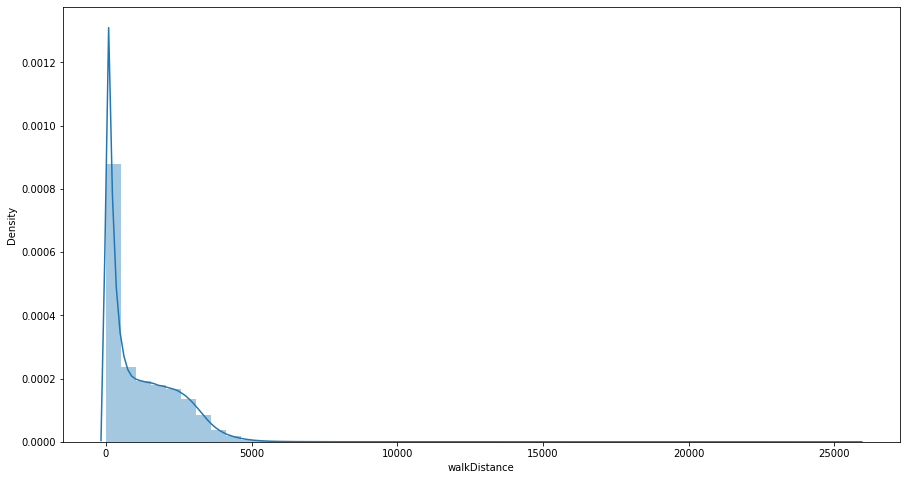

In [74]:
show_distplot('walkDistance')

In [75]:
train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,0,0,0,0.0,1906,solo,99,93,1517,0,0.421200,0,9.882000,0,0,13530.0,7,0,0.8163,13540.302734,0.0,False
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.000000,0,0,0,46,0,0,0,0.0,1889,solo-fpp,95,93,1520,0,0.007800,0,381.899994,0,0,25780.0,0,0,0.9894,26161.908203,0.0,False
1072113,692e7657b6e340,10baa5ce3cdffe,ad7403ad4d20a9,0,1,0.000000,0,0,5,50,0,0,0,0.0,1962,squad-fpp,29,27,1478,0,0.019800,0,15.270000,1,0,13040.0,4,0,0.6786,13055.289062,0.0,False
1137979,3c23cf6c61171f,90b6aaaa2a16b7,a52c5ac7c18311,0,2,0.000000,0,0,27,41,0,0,0,0.0,1869,squad-fpp,29,29,1470,0,0.054800,0,80.339996,0,0,13160.0,3,0,0.9643,13240.394531,0.0,False
1188935,2dd8f83eb3bd7f,d1e7809ff69bb4,c8585bc8a88aa6,0,0,0.000000,0,0,0,44,0,0,0,0.0,1811,squad-fpp,29,27,1407,0,1258.000000,0,180.699997,0,0,13360.0,4,0,0.9643,14798.700195,0.0,False
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.000000,0,0,0,55,0,0,0,0.0,1977,squad-fpp,26,25,1482,0,0.040100,0,129.399994,0,0,16250.0,3,0,0.6000,16379.440430,0.0,False
2078996,1284474083cc33,fa7e10443cc7df,c62835e88e61a6,0,2,0.000000,0,0,3,48,0,0,0,0.0,2012,squad-fpp,31,31,1474,0,847.700012,0,256.899994,0,0,14250.0,8,0,0.8000,15354.600586,0.0,False
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.000000,0,0,5,46,0,0,0,0.0,1828,solo,97,95,1651,0,0.011100,0,389.500000,0,0,15370.0,7,0,0.8125,15759.510742,0.0,False
2990339,fc3fdd39dcd266,f901321bc27871,c0ebfb404aaa47,0,4,75.349998,0,0,0,40,0,0,0,0.0,1805,squad-fpp,29,29,1542,0,1790.000000,0,42.189999,0,0,13070.0,4,0,0.9286,14902.190430,0.0,False
3318429,25a548c95fa48f,978df298b094ba,99407bcde7569c,0,0,0.000000,0,0,2,39,0,0,0,0.0,1867,solo-fpp,93,89,1803,0,0.013900,0,38.439999,0,0,13660.0,1,0,0.8913,13698.454102,0.0,False


In [77]:
train.drop(train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)].index, inplace=True)

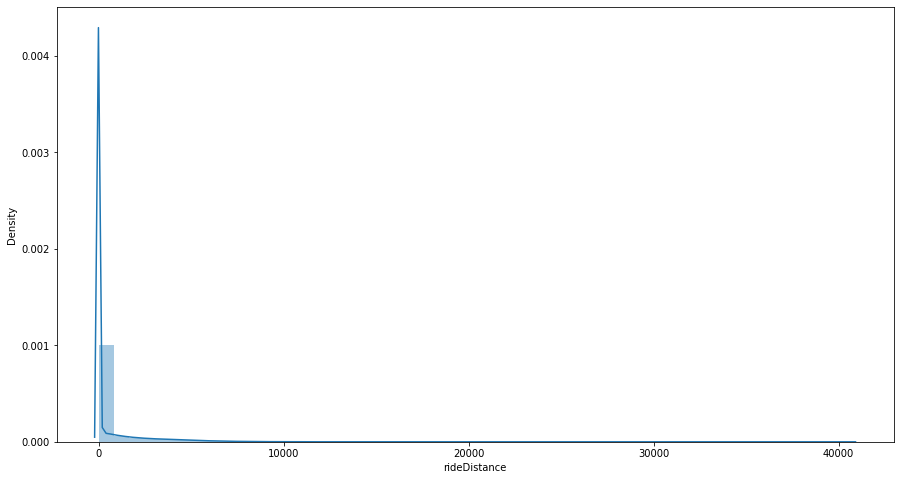

In [78]:
show_distplot('rideDistance')

In [79]:
train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,1120,0,0,0.0,2007,solo,83,83,-1,0,31960.0,0,0.0,0,0,402.100006,3,1449,0.8171,32362.099609,0.0,False
605623,8dee54600c67ca,e77f3e175b5959,26bc606cdae6bf,0,0,11.210000,0,0,0,27,1179,0,0,0.0,1851,solo,51,50,-1,0,33970.0,0,0.0,0,0,1641.000000,0,1498,0.6800,35611.000000,0.0,False
1232362,4bf27787223351,b0140dd17f3238,5ed9c405f7e71d,0,1,0.000000,0,0,10,47,0,0,0,0.0,1896,solo,95,91,1501,0,31010.0,0,0.0,1,0,1473.000000,3,0,0.7979,32483.000000,0.0,False
1725337,9f14f77b6dd9b6,8a2a8ae2506323,904b5fa7f59bc5,0,2,2.389000,0,0,5,19,1193,0,0,0.0,1918,solo-fpp,37,35,-1,0,37670.0,0,0.0,0,0,542.099976,2,1565,0.6944,38212.101562,0.0,False
2137063,73b793b4e7523f,f4444641af7e5c,6385f7641268c3,0,0,0.000000,0,0,0,52,0,0,0,0.0,1794,solo-fpp,94,92,1512,0,31370.0,0,0.0,0,0,28.760000,0,0,0.7204,31398.759766,0.0,False
2700691,3428324a089608,fa77b4ac736dbf,9b1c87f4016f47,0,1,31.270000,0,0,0,46,1211,0,0,0.0,1886,solo-fpp,98,95,-1,0,31290.0,0,0.0,0,0,174.100006,1,1530,0.8557,31464.099609,0.0,False
2927408,260efc0cf6b36c,b112f8d21e8185,3e977510ce1d3c,0,0,11.220000,0,0,0,44,1281,0,0,0.0,1865,solo,92,90,-1,0,30660.0,0,0.0,0,0,426.600006,2,1619,0.8132,31086.599609,0.0,False
3404578,8e84f4228e5436,c5ca5892142cbd,56775920f704e8,0,0,3.298000,0,0,0,40,1060,0,0,0.0,1877,solo-fpp,98,96,-1,0,32320.0,0,0.0,0,0,233.699997,5,1497,0.9175,32553.699219,0.0,False
3567265,99f342c6022411,9158efebffecc7,ddbe41fe165c7f,2,2,113.199997,0,0,3,34,0,0,0,0.0,1958,duo-fpp,48,47,1729,1,31020.0,0,0.0,0,0,616.200012,4,0,1.0000,31636.199219,0.0,False
4099938,afe34618b04d77,c14f532b283844,732c3b752e055f,0,0,0.000000,0,0,0,42,0,0,0,0.0,1939,solo-fpp,93,90,1486,0,40710.0,0,0.0,0,0,560.099976,0,0,0.8478,41270.101562,0.0,False


In [42]:
train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
219621,49e86bcbb74918,5bf4ac7f5f89a0,05a97d10e3cf81,0,0,100.000000,1,0,0,38,0,1,1,2.150000,1979,squad,26,26,1465,0,673.099976,1,0.0,0,0,0.0,0,0,0.0000,673.099976,0.0,False
1051447,c43116d1c3d4e5,bd09c97b67800a,aad60eee7eeb79,0,0,102.199997,0,0,0,34,1320,1,1,4.489000,1935,solo,89,85,-1,0,1757.000000,1,0.0,0,0,0.0,0,1532,0.1250,1757.000000,0.0,False
1053213,4a8011f19b0e0e,037c89b0cef255,238171821a1d0e,1,0,100.000000,1,0,0,38,1621,1,1,1.440000,1881,duo,48,45,-1,0,36.240002,0,0.0,0,0,0.0,0,1747,0.0638,36.240002,0.0,False
1166930,553f199b5538c5,560c2ba9dcbbd0,afb05e37d884fc,2,0,168.500000,1,0,0,45,1398,1,1,3.268000,1799,squad,31,29,-1,0,391.799988,1,0.0,0,0,0.0,0,1499,0.0667,391.799988,0.0,False
1479750,bcdf0f6c5d08bf,ea2ed2cc5955dd,2b59ed013eaf15,0,0,100.000000,1,0,0,46,0,1,1,3.744000,1882,duo,50,47,1509,0,468.299988,1,0.0,0,0,0.0,0,0,0.0612,468.299988,0.0,False
2221273,a280df87d394fc,61042f8c96538c,a0e8fe0599288c,0,0,100.000000,1,0,0,37,0,1,1,4.656000,1982,duo,47,44,1506,0,534.500000,1,0.0,0,0,0.0,0,0,0.1522,534.500000,0.0,False
2382410,adbda59d2f11cd,343d453ffb18c8,cbb5f864c6f532,0,0,100.000000,1,0,0,43,0,1,1,1.564000,1807,squad,26,22,1530,0,262.700012,1,0.0,0,0,0.0,0,0,0.0000,262.700012,0.0,False
2471705,b968373063f5a8,536e9c19659ce8,61c90034dc8174,0,0,93.470001,1,0,0,38,0,1,1,3.395000,1758,squad,29,26,1500,0,1360.000000,1,0.0,0,0,0.0,0,0,0.1429,1360.000000,0.0,False
2907639,2bf1d34142358b,71c15011651348,08dfa30b9390f7,4,0,578.000000,0,0,6,30,0,3,1,17.719999,1007,squad,6,6,1500,0,1277.000000,0,0.0,0,0,0.0,29,0,0.4000,1277.000000,0.0,False
3778837,ca3ca72549b07f,68a0c84f3b09aa,f72f06cafb3349,0,0,144.300003,2,0,0,20,1183,2,1,5.206000,1785,squad,28,26,-1,0,415.399994,0,0.0,0,0,0.0,0,1496,0.0000,415.399994,0.0,False


In [44]:
train[(train['totalDistance'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,0,0,0,0.0,1530,duo,46,44,1534,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,311,0,0,0.0,1414,duo,41,36,0,0,0.0,0,0.0,0,0,0.0,0,847,0.0000,0.0,0.0,False
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,309,0,0,0.0,1377,duo,48,41,-1,0,0.0,0,0.0,0,0,0.0,0,765,0.0000,0.0,0.0,False
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,1397,0,0,0.0,1358,squad,29,26,-1,0,0.0,0,0.0,0,0,0.0,0,1510,0.0000,0.0,0.0,False
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,0,0,0,0.0,1797,duo,48,47,1500,0,0.0,0,0.0,0,0,0.0,0,0,0.1277,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446843,56f1ff8594a328,63008ee9676bc3,b3f07953e112dc,0,0,0.0,0,0,0,99,0,0,0,0.0,1902,squad,30,30,1456,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
4446849,19d2b52c9e17a3,f8a952ce9ab7aa,2afb2889026133,0,0,0.0,0,0,0,90,1243,0,0,0.0,1472,solo,98,93,-1,0,0.0,0,0.0,0,0,0.0,0,1363,0.0412,0.0,0.0,False
4446905,f93dfebceecc59,c54ca5bb9df107,e1da3a1ee799ef,0,0,0.0,0,0,0,89,0,0,0,0.0,1371,duo,49,48,1465,0,0.0,0,0.0,0,0,0.0,1,0,0.0417,0.0,0.0,False
4446926,e0c791ea3c4644,e18240dcce54f9,827639896a20cb,0,0,0.0,0,0,0,87,526,0,0,0.0,1811,squad,29,29,-1,0,0.0,0,0.0,0,0,0.0,0,916,0.0000,0.0,0.0,False


In [57]:
# droping riding walking totalDistance anomalies
train.drop(train[(train['rideDistance'] >= 2500) & (train['kills'] == 0)].index, inplace = True)
train.drop(train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)].index, inplace = True)
train.drop(train[(train['totalDistance'] == 0)].index, inplace=True)

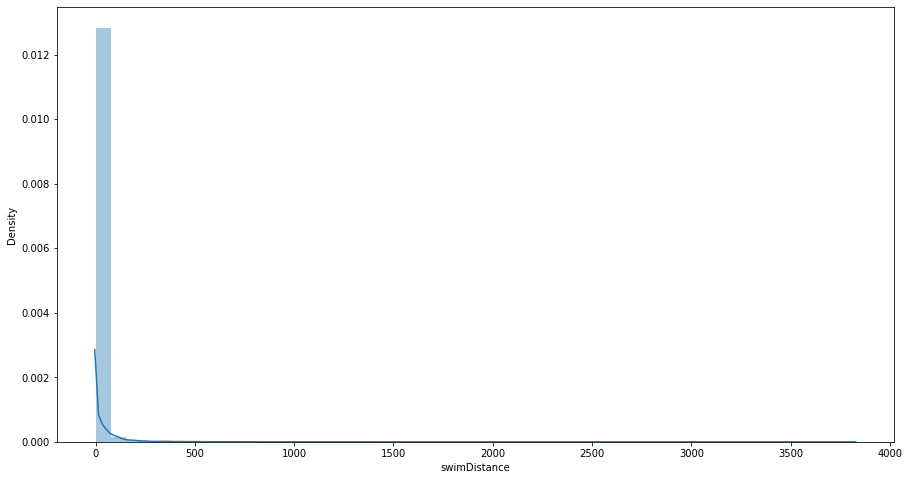

In [47]:
show_distplot('swimDistance')

In [80]:
train[train['swimDistance'] >= 1500]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.120003,1,0,1,47,1058,0,0,0.000000,1399,duo-fpp,50,46,-1,0,0.000000,0,2295.0,0,0,1002.000000,4,1466,0.9592,3297.000000,0.000000,False
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.320000,0,0,16,39,0,0,0,0.000000,2188,squad,26,25,1584,0,5689.000000,0,2148.0,0,0,2276.000000,5,0,0.9600,10113.000000,0.000000,False
605711,b858eac7f45356,7e22dfa27537a3,0dcda56c3bc67f,0,0,0.000000,0,0,0,61,0,0,0,0.000000,1838,squad,28,28,1394,0,1017.000000,0,1537.0,0,0,1036.000000,4,0,0.4074,3590.000000,0.000000,False
766045,ae710823886ef8,a5b9e8492789e3,7d58954d409084,0,0,100.000000,1,0,0,60,1307,0,0,0.000000,1779,squad-fpp,28,28,-1,1,0.007800,0,1542.0,0,0,1928.000000,0,1503,0.5556,3470.007812,0.000000,False
845213,3e0ae6d0e5c266,0b979aaa539ccd,9f4959a9f9c133,0,0,0.000000,0,0,0,45,1304,0,0,0.000000,1964,solo-fpp,94,91,-1,0,0.000000,0,1974.0,0,0,18.680000,0,1587,0.8495,1992.680054,0.000000,False
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.000000,4,3,1,6,1103,3,1,868.700012,1897,squad,26,25,-1,0,3331.000000,0,2718.0,0,0,4691.000000,5,1516,1.0000,10740.000000,1.000000,False
1043642,8c53ba14c472dc,174c103146edbf,0dcda56c3bc67f,0,0,0.000000,0,0,0,49,0,0,0,0.000000,1838,squad,28,28,1483,0,1904.000000,0,1870.0,0,0,1176.000000,3,0,0.5926,4950.000000,0.000000,False
1092681,4ffd9c73f52189,cec32f01bb36fd,e23cf41f823ff3,2,5,263.899994,1,0,4,12,0,2,1,44.279999,1874,duo-fpp,50,47,1496,0,0.000000,0,1980.0,0,0,1341.000000,4,0,0.9592,3321.000000,0.000000,False
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.299988,3,1,6,4,1039,5,1,64.480003,1396,duo-fpp,49,48,-1,0,0.000000,0,2668.0,0,0,415.100006,10,1499,1.0000,3083.100098,0.200000,False
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.200012,3,1,1,46,0,2,1,48.209999,1021,normal-squad-fpp,12,12,1500,0,0.000000,0,3823.0,0,0,995.299988,9,0,1.0000,4818.299805,0.500000,False


In [81]:
# Remove swim anomalies
train.drop(train[train['swimDistance'] >= 1500].index, inplace=True)

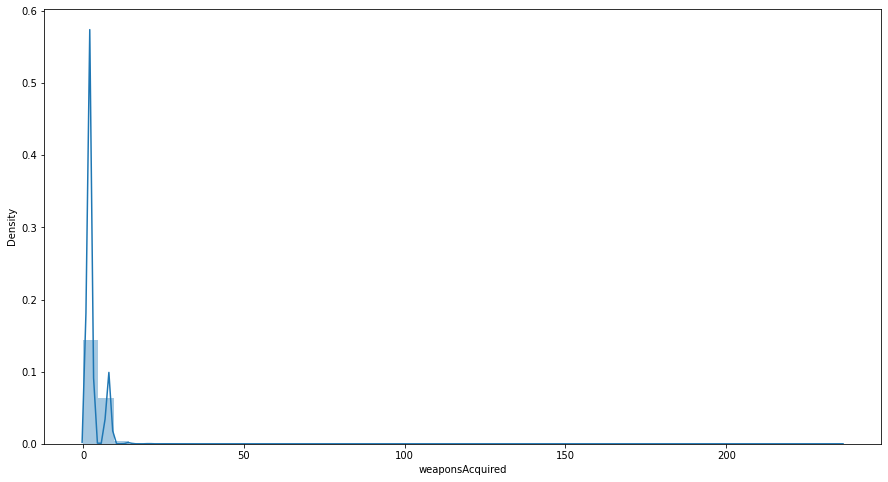

In [82]:
show_distplot('weaponsAcquired')

In [83]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(21, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,1279,0,0,0.000000,1901,duo,46,45,-1,0,1880.000000,0,0.000000,0,0,1307.000000,128,1577,0.7111,3187.000000,0.000000,False
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.300003,1,0,2,48,0,0,0,0.000000,1372,squad,29,29,1473,0,0.000000,0,0.000000,0,0,1687.000000,80,0,0.7500,1687.000000,0.000000,False
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,0,1,1,110.599998,1840,squad-fpp,29,28,1528,0,2852.000000,0,47.209999,0,0,2400.000000,102,0,0.8929,5299.209961,0.000000,False
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000000,0,0,0,54,0,0,0,0.000000,1330,squad-fpp,26,23,1442,0,0.000000,0,0.000000,0,0,653.099976,95,0,0.5600,653.099976,0.000000,False
1462706,be4ff9afaa5bb1,abb73dd57619fa,f900de1ec39fa5,22,0,5377.000000,0,8,4,3,0,53,3,53.610001,1798,normal-solo-fpp,11,11,1500,0,954.400024,0,0.000000,0,0,1128.000000,83,0,0.8000,2082.399902,0.150943,False


In [84]:
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

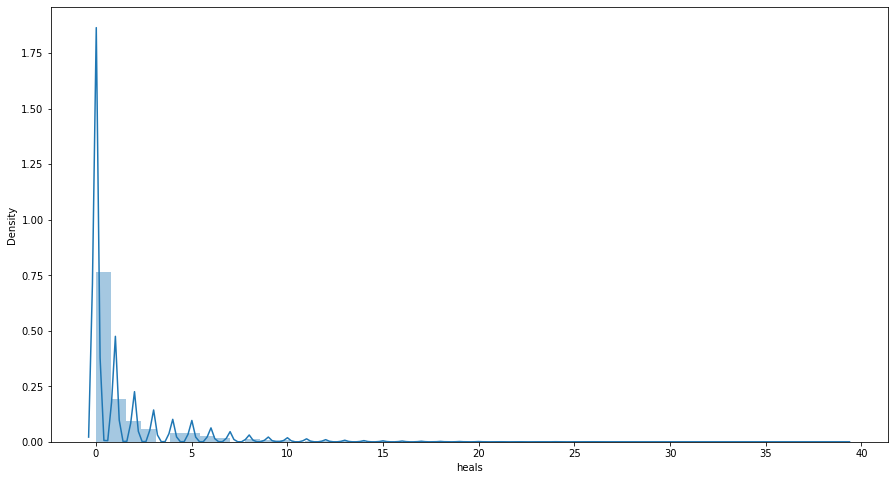

In [88]:
show_distplot('heals')

In [86]:
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,0,0,0,0.000000,1797,solo-fpp,96,92,1527,0,5467.000000,0,0.000000,0,0,1387.000000,6,0,0.9368,6854.000000,0.000000,False
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,0,1,1,5.515000,1532,squad,27,27,1500,0,0.000000,0,292.399994,0,0,2791.000000,7,0,0.9615,3083.399902,1.000000,False
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,1331,0,0,0.000000,1374,solo-fpp,97,96,-1,0,0.000000,0,3.443000,0,0,1340.000000,3,1543,0.8333,1343.442993,0.000000,False
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,0,0,0,0.000000,1769,solo-fpp,97,94,1563,0,5934.000000,0,0.000000,0,0,1510.000000,6,0,0.8646,7444.000000,0.000000,False
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,0,0,0,0.000000,1878,solo-fpp,93,93,1500,0,3848.000000,0,0.000000,0,0,1968.000000,9,0,0.8370,5816.000000,0.000000,False
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,1359,0,0,0.000000,1295,squad-fpp,28,28,-1,0,0.000000,0,0.000000,0,0,2439.000000,2,1511,0.9259,2439.000000,0.000000,False
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,0,0,0,0.000000,1965,squad-fpp,30,29,1506,0,2596.000000,0,0.000000,0,0,2252.000000,8,0,0.8276,4848.000000,0.000000,False
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,1254,1,1,33.310001,1358,squad-fpp,32,31,-1,0,487.600006,0,0.000000,0,0,2928.000000,3,1562,0.9355,3415.600098,1.000000,False
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,1000,27,3,87.190002,1797,normal-solo-fpp,37,22,-1,0,0.000000,0,0.000000,0,0,268.799988,33,1500,0.8889,268.799988,0.296296,False
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,1034,4,2,35.419998,1807,squad,28,25,-1,1,2438.000000,0,0.000000,0,0,2489.000000,6,1517,0.9630,4927.000000,0.250000,False


In [87]:
train.drop(train[train['heals'] >= 40].index, inplace=True)

In [89]:
train.shape

(4446772, 32)

# **Adding/Removing some features**

In [92]:
train.to_csv('/content/drive/My Drive/PUBG/cleaned_data.csv', index=False)

In [95]:
import pandas as pd
cleaned_data = pd.read_csv('/content/drive/My Drive/PUBG/cleaned_data.csv')
cleaned_data = reduce_mem_usage(cleaned_data)

Memory usage of dataframe is 1055.95 MB --> 385.91 MB (Decreased by 63.5%)


In [96]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0


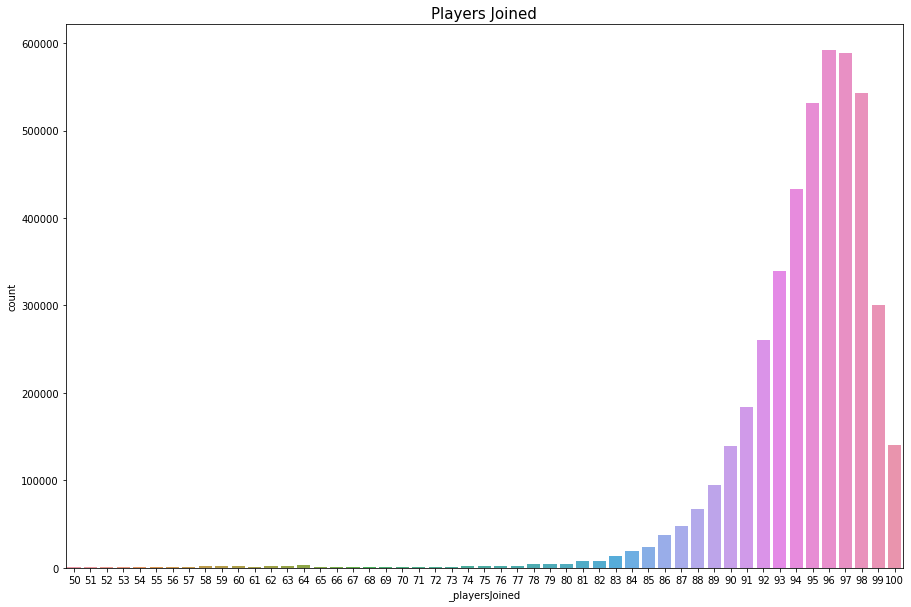

In [98]:
cleaned_data['_playersJoined'] = cleaned_data.groupby('matchId')['matchId'].transform('count')
data = cleaned_data.copy()
data = data[data['_playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['_playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

In [99]:
# Create normalized features
cleaned_data['_killsNorm'] = cleaned_data['kills']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_damageDealtNorm'] = cleaned_data['damageDealt']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_maxPlaceNorm'] = cleaned_data['maxPlace']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_matchDurationNorm'] = cleaned_data['matchDuration']*((100-cleaned_data['_playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','_killsNorm','damageDealt', '_damageDealtNorm', 'maxPlace', '_maxPlaceNorm', 'matchDuration', '_matchDurationNorm']
cleaned_data[to_show][0:11]

,Id,kills,_killsNorm,damageDealt,_damageDealtNorm,maxPlace,_maxPlaceNorm,matchDuration,_matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470001,99.702301,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000000,69.360000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900002,35.861002,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000000,103.000000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000000,105.000000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538000,8.879520,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.599998,53.147998,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270000,38.388100,29,29.87,1930,1987.90


In [100]:
match = cleaned_data.groupby('matchId')
cleaned_data['_killsPerc'] = match['kills'].rank(pct=True).values
cleaned_data['_killPlacePerc'] = match['killPlace'].rank(pct=True).values
cleaned_data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
cleaned_data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
cleaned_data['_walkPerc_killsPerc'] = cleaned_data['_walkDistancePerc'] / cleaned_data['_killsPerc']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,96,0.00,0.000000,29.12,1358.24,0.302083,0.625000,0.479167,0.156250,1.586207
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,91,0.00,99.702301,28.34,1936.93,0.252747,0.626374,0.560440,0.439560,2.217391
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,98,0.00,69.360000,51.00,1344.36,0.290816,0.479592,0.377551,0.448980,1.298246
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,97,1.03,103.000000,99.91,1466.72,0.670103,0.463918,0.206186,0.577320,0.307692


In [102]:
corr = cleaned_data[['_killsPerc', '_killPlacePerc','_walkDistancePerc','_damageDealtPerc', '_walkPerc_killsPerc','winPlacePerc']].corr()

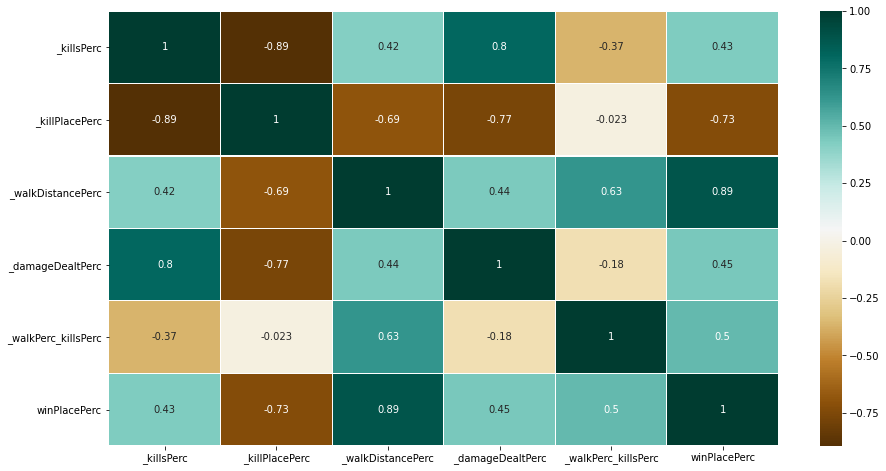

In [105]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="BrBG"
)
plt.show()

In [107]:
agg = cleaned_data.groupby(['groupId']).size().to_frame('players_in_team')
cleaned_data = cleaned_data.merge(agg, how='left', on=['groupId'])
cleaned_data['_healthItems'] = cleaned_data['heals'] + cleaned_data['boosts']
cleaned_data['_headshotKillRate'] = cleaned_data['headshotKills'] / cleaned_data['kills']
cleaned_data['_killPlaceOverMaxPlace'] = cleaned_data['killPlace'] / cleaned_data['maxPlace']
cleaned_data['_killsOverWalkDistance'] = cleaned_data['kills'] / cleaned_data['walkDistance']
cleaned_data['_killsOverDistance'] = cleaned_data['kills'] / cleaned_data['totalDistance']
cleaned_data['_walkDistancePerSec'] = cleaned_data['walkDistance'] / cleaned_data['matchDuration']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team_x,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,players_in_team_y,_killsOverDistance,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,96,0.00,0.000000,29.12,1358.24,0.302083,0.625000,0.479167,0.156250,1.586207,4,0,NaN,2.142857,0.000000,4,0.000000,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,91,0.00,99.702301,28.34,1936.93,0.252747,0.626374,0.560440,0.439560,2.217391,4,0,NaN,2.192308,0.000000,4,0.000000,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,98,0.00,69.360000,51.00,1344.36,0.290816,0.479592,0.377551,0.448980,1.298246,2,0,NaN,0.940000,0.000000,2,0.000000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,NaN,2.419355,0.000000,1,0.000000,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,97,1.03,103.000000,99.91,1466.72,0.670103,0.463918,0.206186,0.577320,0.307692,1,0,0.0,0.463918,0.020101,1,0.020101,0.034937


In [109]:
corr = cleaned_data[['killPlace', 'walkDistance','_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', '_killsOverDistance','_walkDistancePerSec','winPlacePerc']].corr()

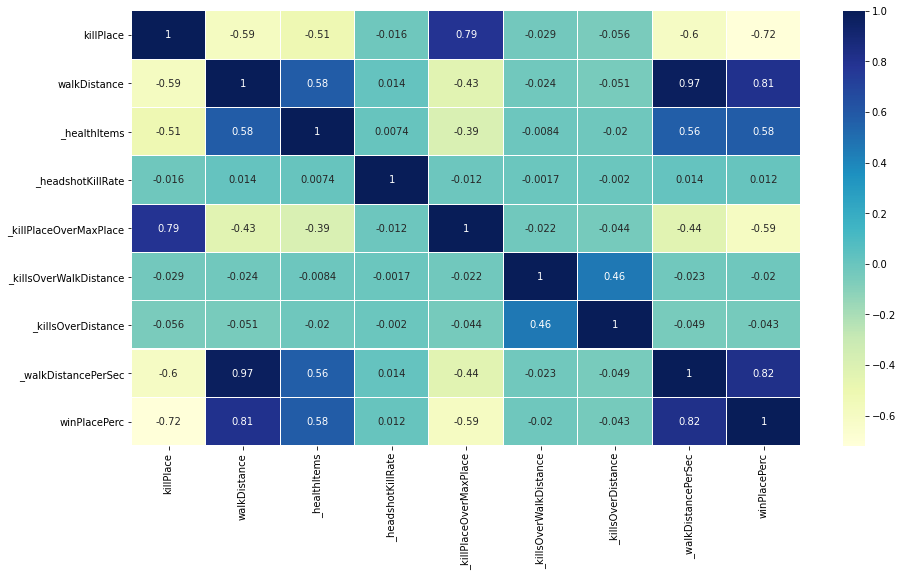

In [110]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="YlGnBu"
)
plt.show()

In [111]:
cleaned_data.shape

(4446772, 50)

In [112]:
cleaned_data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'totalDistance',
       'headshot_rate', '_killsWithoutMoving', '_playersJoined', '_killsNorm',
       '_damageDealtNorm', '_maxPlaceNorm', '_matchDurationNorm', '_killsPerc',
       '_killPlacePerc', '_walkDistancePerc', '_damageDealtPerc',
       '_walkPerc_killsPerc', 'players_in_team_x', '_healthItems',
       '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance',
       'players_in_team_y', '_killsOverDistance', '_walkDistancePerSec'],
      dtype='object')

In [113]:
cleaned_data.drop(['_headshotKillRate','_killsOverDistance', '_killsOverWalkDistance', ], axis=1, inplace=True)

In [114]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team_x,_healthItems,_killPlaceOverMaxPlace,players_in_team_y,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,96,0.00,0.000000,29.12,1358.24,0.302083,0.625000,0.479167,0.156250,1.586207,4,0,2.142857,4,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,91,0.00,99.702301,28.34,1936.93,0.252747,0.626374,0.560440,0.439560,2.217391,4,0,2.192308,4,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,98,0.00,69.360000,51.00,1344.36,0.290816,0.479592,0.377551,0.448980,1.298246,2,0,0.940000,2,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,1,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,97,1.03,103.000000,99.91,1466.72,0.670103,0.463918,0.206186,0.577320,0.307692,1,0,0.463918,1,0.034937


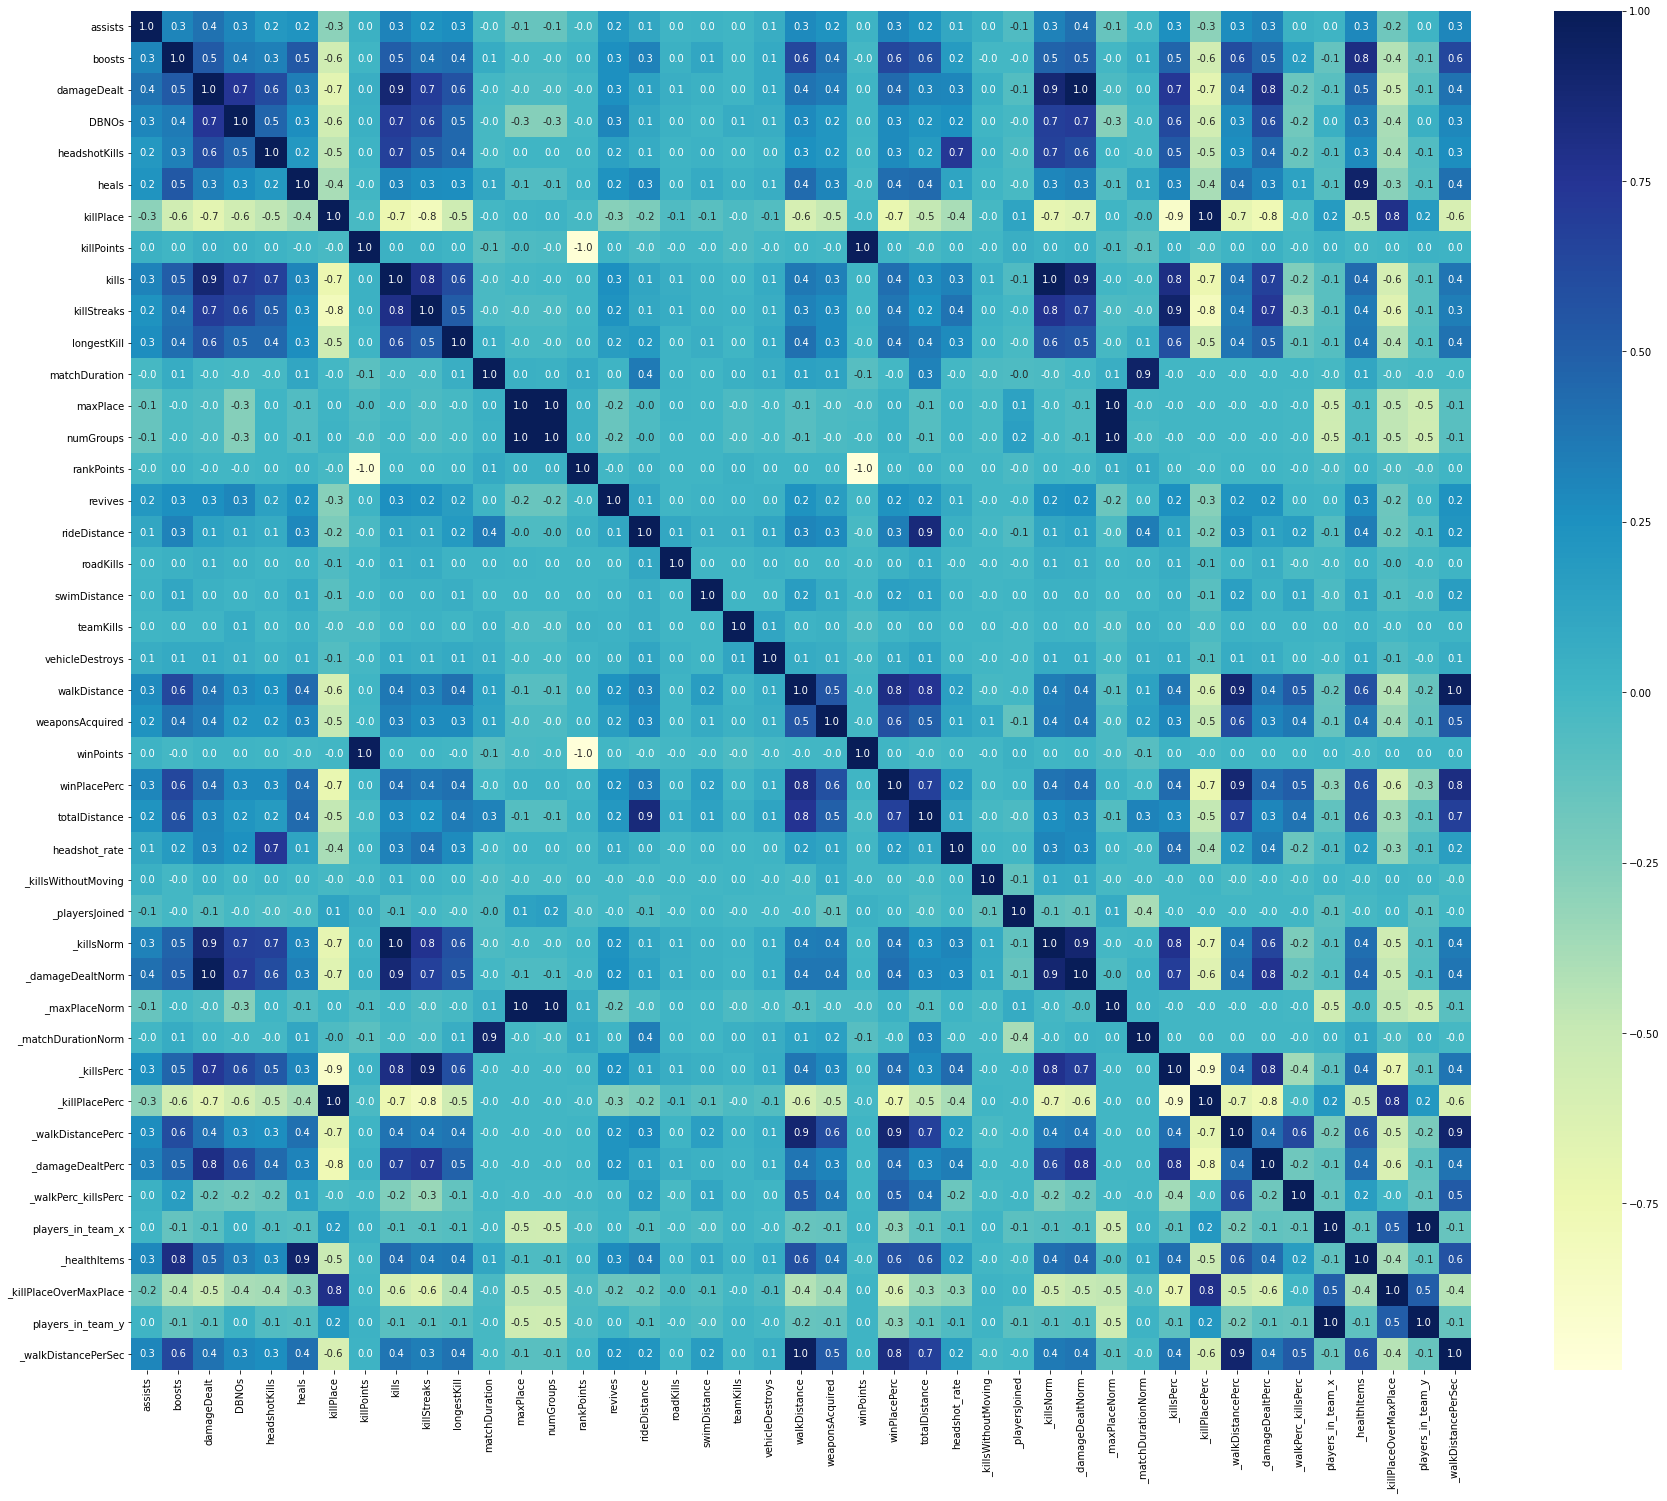

In [115]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 25))
sns.heatmap(cleaned_data[cols_to_fit].corr(), annot=True, fmt= '.1f',ax=ax, cmap="YlGnBu")
sns.set(font_scale=1.25)
plt.show()

##Removing features having 0 correlation with winPlacePerc

In [116]:
cleaned_data.drop(['killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','teamKills','winPoints', '_playersJoined', '_maxPlaceNorm', '_matchDurationNorm', '_killsWithoutMoving'], axis=1, inplace=True)

In [ ]:
cleaned_data.drop(['players_in_team_y','_walkDistancePerSec','_killPlaceOverMaxPlace','_healthItems','players_in_team_x',], axis=1, inplace=True)

In [139]:
cleaned_data.shape

(4446772, 30)

In [140]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchType,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,headshot_rate,_killsNorm,_damageDealtNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,0,0,0.000000,squad-fpp,0,0.0000,0.00,0,244.800003,1,0.4444,244.800003,0.0,0.00,0.000000,0.302083,0.625000,0.479167,0.156250,1.586207
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0.000000,squad-fpp,0,0.0045,11.04,0,1434.000000,5,0.6400,1445.044556,0.0,0.00,99.702301,0.252747,0.626374,0.560440,0.439560,2.217391
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0.000000,duo,0,0.0000,0.00,0,161.800003,2,0.7755,161.800003,0.0,0.00,69.360000,0.290816,0.479592,0.377551,0.448980,1.298246
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0.000000,squad-fpp,0,0.0000,0.00,0,202.699997,3,0.1667,202.699997,0.0,0.00,35.861002,0.274725,0.824176,0.230769,0.296703,0.840000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,1,1,58.529999,solo-fpp,0,0.0000,0.00,0,49.750000,2,0.1875,49.750000,0.0,1.03,103.000000,0.670103,0.463918,0.206186,0.577320,0.307692


In [141]:
cleaned_data.drop(['headshot_rate'], axis=1, inplace=True)

In [142]:
cleaned_data.shape

(4446772, 29)

In [145]:
test.shape

(1934174, 28)

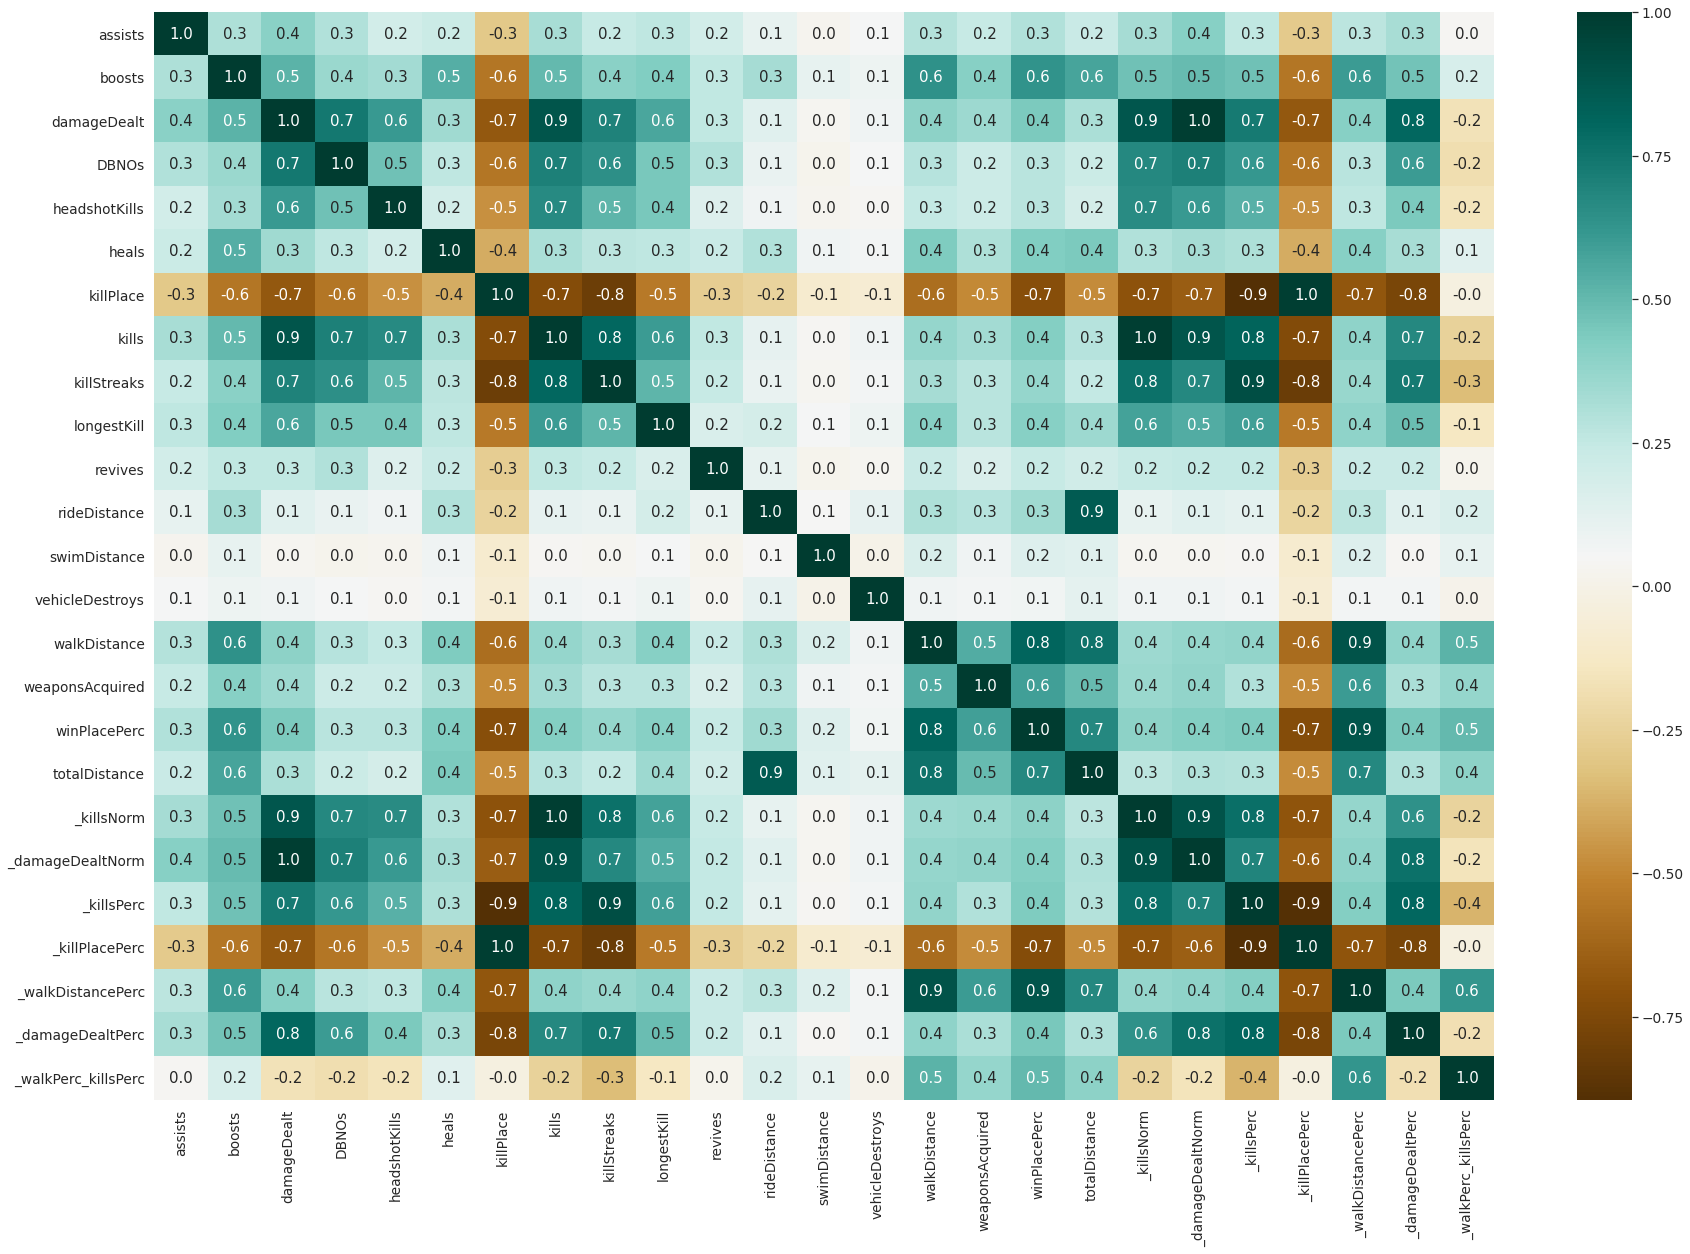

In [146]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr, annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

In [147]:
#saving highly correlated data
cleaned_data.to_csv(  '/content/drive/My Drive/PUBG/Highly_correlated_data.csv', index=False)